In [1699]:
import cv2
import sys
import os
import numpy as np
import time
from IPython.display import clear_output
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [94]:
f = open('./dist_map.txt', 'rb')

old_points = np.array(np.str(f.read())[2:-1].split(' ')).astype(np.float32)

In [160]:
def load_visual_coord(src='./dist_map.txt'):
    f = open(src, 'r')
    coord = f.read()
    f.close()
    vis = np.array(coord.split(' '), dtype=np.float32).reshape(-1, 2).astype(np.float32) / 100
    return vis

In [1901]:
def load_point_cloud(src='./../../../Desktop/new_cloud_lazer.npy'):
    point_cloud = np.load(src)[:,:-1][:-1][::-1]
    shape = point_cloud.shape[0]
#     if shape < 784:
#         raise Exception('Point cloud have invalid shape. %s < 784.'%shape)
#     delete_num = shape - 784

#     delete_ind = np.random.choice(range(1, shape-1), delete_num, replace=False)
#     point_cloud = np.delete(point_cloud, delete_ind, 0)
    point_cloud = np.array(list(map(lambda a: [a[1], a[0]], point_cloud)))
    return point_cloud

In [1256]:
old = load_visual_coord()

In [2061]:
new = load_point_cloud(src='./../../../Desktop/new_cloud_813.npy')[:-1]

In [1851]:
# plt.scatter((old[:,0]*10).astype(np.int32), (old[:,1]*10).astype(np.int32))
# plt.show()#[:120])
# plt.scatter(np.round(old[:,0]*100), np.round(old[:,1]*100))#[:120])


In [1911]:
from PIL import Image

In [2064]:
img_full = Image.open('./images/img/116.png')
img = img_full.resize((28, 28))
img = (np.array(img)/255.).copy()

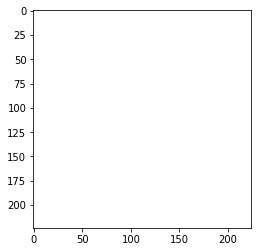

In [2066]:
plt.imshow(img_full)

In [2067]:
img = img.reshape(-1, 3)

In [2068]:
from collections import defaultdict
di = defaultdict(list)
for i, im in enumerate(img):
    di[tuple(((new[i][0]*100).astype(np.int32), (new[i][1]*100).astype(np.int32)))].append(im)

In [2069]:
#sum(stats.mode(i)[0][0]) > 2
scat = {}
for k, i in di.items():
    if [0., 0., 1.] in np.array(i).tolist():
        scat[k] = 0
    else:
        scat[k] = 1
#     if list(k) in a:
#         scat[k] = 4
items = [[[*k], v] for k, v in scat.items()]
keys_1 = np.array(list(map(lambda m: m[0], items)))
values_1 = np.array(items)[:,-1]

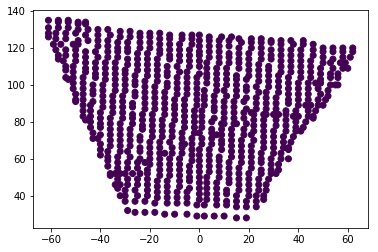

In [2070]:
# plt.imshow(img.reshape(-1, 28, 3))
# plt.show()
# plt.scatter(keys[:,0], keys[:,1], c=values)
plt.scatter(keys_1[:,0], keys_1[:,1], c=values_1)

In [2071]:
field = np.zeros((len(keys[:,0]) + 50,  len(keys[:,1]) + 50))

In [2072]:
for sc in scat:
    field[sc[0] + int(field.shape[0]/2), sc[1] + int(field.shape[1]/2)] = 1
vertex = []
for i, cell in enumerate(field):
    for nozero in np.where(cell != 0)[0]:
        vero = np.mean(field[i-10: i+10, nozero-10: nozero+10])
        vertex.append([i, nozero, vero])
sort_ver = sorted(vertex, key=lambda a: a[2], reverse=False)[:20]
num = []
means = (keys[:,0].max() - keys[:,0].min())/4 + (keys[:,1].max() - keys[:,1].min())/4
trying = True
for i in sort_ver:
    trying = True
    ang_vert = [i[0] - int(field.shape[0]/2), i[1] - int(field.shape[1]/2)]
    if len(num) != 0:
        for vert in num:
            x_dif = np.abs(vert[0] - ang_vert[0])
            y_dif = np.abs(vert[1] - ang_vert[1])
            if (x_dif + y_dif)/2 > means:
                continue
            else:
                trying = False
                break
    if trying:
        scat[tuple(ang_vert)] = 2
        num.append([i[0] - int(field.shape[0]/2), i[1] - int(field.shape[1]/2)])
if 2 < len(num) < 4:
    num = np.array(num)
    if len(np.where(np.array(num)[:,0] > 0)[0]) == 2:
        a, b = num[np.where(np.array(num)[:,0] > 0)[0]]
    else:
        a, b = num[np.where(np.array(num)[:,0] < 0)[0]]
    

    #find_dif = sorted(num, key=lambda a:a[1], reverse=True)
    

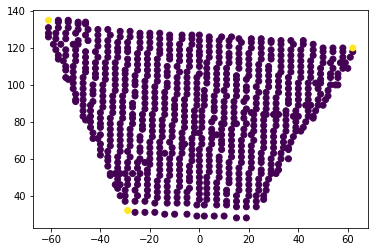

In [2073]:
items = [[[*k], v] for k, v in scat.items()]
keys = np.array(list(map(lambda m: m[0], items)))
values = np.array(items)[:,-1]

plt.scatter(keys[:,0], keys[:,1], c=values)

In [2074]:
def func(a, b, x):
    x1, y1 = b
    x2, y2 = a
    y = -((y1 - y2)*x + (x1*y2 - x2*y1))/ (x2 - x1)
    k = -(y1 - y2)/ (x2 - x1)
    return y, k

In [2075]:
ix = []
for i in np.array(num):
    mx = np.abs(num[:,1] - i[1])
    mx = [x if x > 0 else 100000 for x in mx]
    
    ix.append(np.min(mx))
a, b = num[np.argsort(ix)][:2]

In [2076]:
y, k = func(a, b, range(0, 100))

In [2077]:
num

array([[-29,  32],
       [ 62, 120],
       [-61, 135]], dtype=int64)

In [2079]:
x1, y1 = num[0]
x = np.arange(-40, 30)
y2 = k*x - k*x1 + y1

In [2080]:
from scipy.spatial import distance
new_point = []
if x1 in x[:int(len(x)/2)]:
    x = x[::-1]
    y2 = y2[::-1]
for point in zip(x, y2):
    dist = []
    point = list(map(int, point))
    for key in keys.tolist():
        dist.append(distance.euclidean(key, point))
    new_point.append(keys[np.argmin(dist)])
if len(num) < 4:
    num = np.vstack((num, stats.mode(new_point[:6])[0][0]))
for n in num:
    scat[tuple(n)] = 2

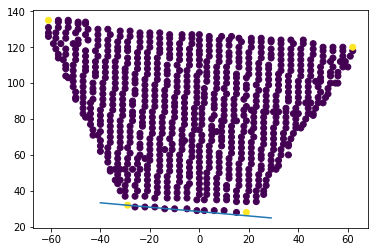

In [2081]:
items = [[[*k], v] for k, v in scat.items()]
keys = np.array(list(map(lambda m: m[0], items)))
values = np.array(items)[:,-1]

plt.scatter(keys[:,0], keys[:,1], c=values)
# plt.plot(y)
plt.plot(x, y2)

In [2082]:
[x for x in num if x not in first]

[array([-29,  32], dtype=int64),
 array([ 62, 120], dtype=int64),
 array([-61, 135], dtype=int64),
 array([19, 28], dtype=int64)]

In [2083]:
left_ang = np.array(sorted(num[np.where(num < 0)[0]], key=lambda a:a[1],reverse=True))
right_ang = np.array(sorted([x for x in num if x not in left_ang], key=lambda a:a[1], reverse=True))

In [2084]:
x_right_ang = np.linspace(*np.array(right_ang)[:,0], num=28)
x_left_ang = np.linspace(*np.array(left_ang)[:,0], num=28)
y_right_ang, _ = func(*right_ang, x_right_ang)
y_left_ang, _ = func(*left_ang, x_left_ang)

In [2085]:
global_points = np.zeros((28, 28, 2))
for i, y_left in enumerate(y_left_ang):
    new_y = np.linspace(y_right_ang[i], y_left, num=28, dtype=np.int32)[::-1]
    new_x = np.linspace(x_right_ang[i], x_left_ang[i], num=28, dtype=np.int32)[::-1]
    for j, coord in enumerate(zip(new_x, new_y)):
        global_points[i][j] = coord
global_points = global_points.reshape(-1, 2)

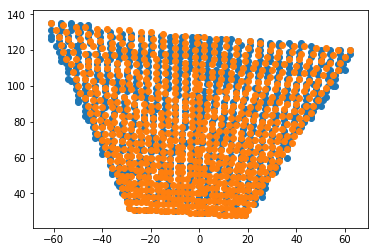

In [2089]:
plt.scatter(keys[:,0], keys[:,1])
plt.scatter(global_points[:,0], global_points[:,1])

In [2091]:
%%timeit
np.savetxt('./bla', np.ones((180, 180), dtype=np.int8))

33.8 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2087]:
np.savetxt("./right_points_2", global_points/100)

In [2088]:
np.loadtxt('./right_points_2')

array([[-0.61,  1.35],
       [-0.56,  1.34],
       [-0.51,  1.33],
       ...,
       [ 0.15,  0.28],
       [ 0.17,  0.28],
       [ 0.19,  0.28]])

In [1630]:
x_right_ang, x_left_ang

(array([70, 68, 66, 64, 63, 61, 59, 57, 56, 54, 52, 50, 49, 47, 45, 43, 42,
        40, 38, 36, 35, 33, 31, 29, 28, 26, 24, 23]),
 array([-62, -60, -59, -58, -57, -56, -54, -53, -52, -51, -50, -48, -47,
        -46, -45, -44, -43, -41, -40, -39, -38, -37, -35, -34, -33, -32,
        -31, -30]))

In [1576]:
step = np.abs(np.diff(np.array(second)[:,0]))[0] / 28

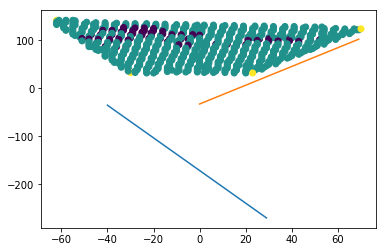

In [1563]:
plt.scatter(keys[:,0], keys[:,1], c=values)
plt.plot(np.arange(-40, 30), y)
plt.plot(np.arange(0, 70), y1)

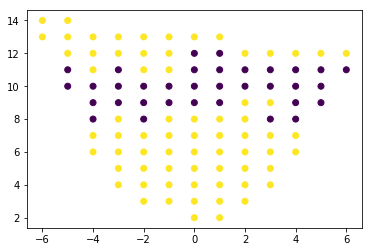

In [574]:
plt.scatter(scat[:,0], scat[:,1], c=scat[:,2])

In [433]:
np.unique((new*10).astype(np.int32)).shape, np.unique(np.round(new*10)).shape

((21,), (21,))

In [530]:
m_m = #sorted(new, key=lambda a: a[1])[0]
m_i = sorted(new, key=lambda a: a[0])[-1]
i_m = [new[:,0].min(), new[:,1].max()]
i_i = [new[:,0].min(), new[:,1].min()]
max_min = np.array([m_m, m_i, i_m, i_i]).reshape(-1, 2)

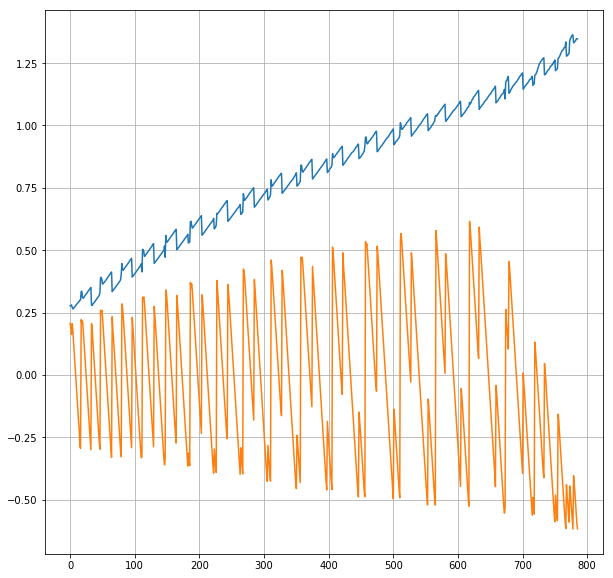

In [118]:
plt.figure(figsize=(10,10))
plt.plot(point_cloud)
plt.grid()

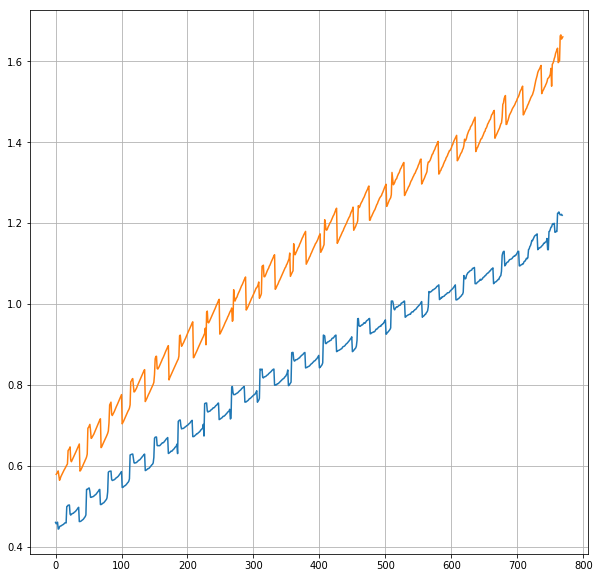

In [56]:
plt.figure(figsize=(10,10))
plt.plot(saved[:,2])
plt.plot(point_cloud[:,0])
plt.grid()

In [53]:
saved = np.load('./../../../Desktop/saved_list.npy')#[:,:-1]

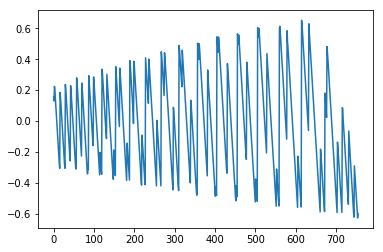

In [23]:
plt.plot([:,1])

In [1934]:
def draw_graph(dicti):
    graph = np.zeros((100, 100), dtype=int)
#     graph[:,0] = np.concatenate([np.arange(10), np.arange(10), np.arange(10), np.arange(7)])
#     graph[0,:] = np.concatenate([np.arange(10), np.arange(10), np.arange(10), np.arange(7)])
    for key, item in dicti.items():
        Tx = key[0]
        Ty = key[1]
        xmatrix = np.round(Tx).astype(int);
        ymatrix = np.round(Ty).astype(int);
#         print(xmatrix," ",ymatrix)
        graph[int(xmatrix + 35 / 2), int(ymatrix + 25 / 2)] = int(item);
#     for i in graph:
#         print(str(i)[1:-1])
    plt.imshow(graph)

In [18]:
f = open('./hello/odom_0.txt', 'r')
val = f.read()
f.close()

In [241]:
f = open('./dist_map.txt'.format(num), 'r')
val = f.read()
f.close()
val = np.array(val.split(' '), dtype=np.float32).reshape(-1, 2)/100

rx = np.cos(odom_val[2])
ry = np.sin(odom_val[2])
mass = []
for i, coord in enumerate(val):
    coord_x = (coord[0] * rx + coord[1] * ry) + odom_val[0]
    coord_y = (-coord[0] * ry + coord[1] * rx) + odom_val[1]
    coords = tuple((np.int(coord_x*10), np.int(coord_y*10)))
    mass.append([np.round(coord_x*10).astype(int), np.round(coord_y*10).astype(int), signs[i]])

In [250]:
not_round = np.array(sorted(val*10, key=lambda a:a[1]))

In [264]:
not_round_set = set((map(tuple, not_round)))

In [259]:
rounds = np.round(np.array(sorted(val*10, key=lambda a:a[1]))).astype(np.int32)

In [266]:
round_set = set(map(tuple,rounds))

[-0.017681, 3.935266, 2.940494, 0.238798]


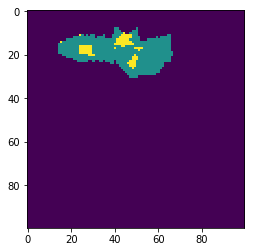

FileNotFoundError: [Errno 2] No such file or directory: './hello/vis_75.txt'

In [1935]:
from collections import defaultdict
global_vis = defaultdict(list)
vis_keys = set()
for num in range(0, 535, 5):
    f = open('./hello/vis_{}.txt'.format(num), 'r')
    val = f.read()
    f.close()

    f = open('./hello/odom_{}.txt'.format(num), 'r')
    odom = f.read()
    f.close()

    val = np.array(list(map(lambda a: np.array(a.split(' '), dtype=np.float32), val.split('\n')[:-1])))
    visual_coord = val.copy()[:,:-1]
    signs = val.copy()[:,-1]
    signs[signs == 0] = 2
    odom_val = list(map(np.float32, odom.split(' ')))

    rx = np.cos(odom_val[2])#+0.1*odom_val[2])
    ry = np.sin(odom_val[2])#+0.1*odom_val[2])
    mass = []
    for i, coord in enumerate(visual_coord):
        coord_x = (coord[0] * rx - coord[1] * ry) + odom_val[0]
        coord_y = (coord[0] * ry + coord[1] * rx) + odom_val[1]
        coords = tuple((np.int(coord_x*10), np.int(coord_y*10)))
        mass.append([coord_x, coord_y, signs[i]])
        global_vis[coords].append(signs[i])
        vis_keys.add(coords)

    mass = np.array(mass)
    val_dict = {}
    for v in mass:
        val_dict[tuple(np.round(v[:2]*10).astype(np.int32))] = int(v[-1])
    for key, item in global_vis.items():
        val_dict[key] = stats.mode(item)[0][0]
    clear_output()
    print(odom_val)
    draw_graph(val_dict)
    plt.show()
    time.sleep(2)

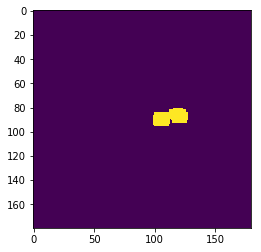

KeyboardInterrupt: 

In [2098]:
for i in range(0, 66, 2):
    graph = np.loadtxt('./hello/graph_{}'.format(i))

    plt.imshow(graph)
    plt.show()
    time.sleep(2)
    clear_output()    

In [57]:
valx

array([[ 0.8674992 ,  1.4878533 ,  1.        ],
       [ 0.80553496,  1.4878533 ,  1.        ],
       [ 0.7435707 ,  1.4878533 ,  1.        ],
       ...,
       [-0.21214269,  0.215     ,  1.        ],
       [-0.2314284 ,  0.215     ,  1.        ],
       [-0.2507141 ,  0.215     ,  1.        ]], dtype=float32)

In [288]:

for a in range(0, 30, 1):
    f = open('./hello/odom_{}.txt'.format(a), 'r')
    va = f.read()
    f.close()

    f = open('./hello/bla.txt'.format(a), 'r')
    val = f.read()
    f.close()

    val = val.split('\n')
    val = np.array(list(map(lambda a: np.array(a.replace(',', '.').split(' '), dtype=np.float32), val[:-1])))
    val_dict = {}#№defaultdict(list)
    val[:,2][val[:,2] == 1] = 1
    val[:,2][val[:,2] == 0] = 2
    for v in val:
        val_dict[tuple(np.round(v[:2]*10).astype(np.int32))] = int(v[-1])
    clear_output()
    print(va)
    draw_graph(val_dict)
    time.sleep(2)
    break

FileNotFoundError: [Errno 2] No such file or directory: './hello/bla.txt'

In [314]:
f = open('./texts/val_{}.txt'.format(a), 'r')
val = f.read()
f.close()

f = open('./texts/map_{}.txt'.format(a), 'r')
map_g = f.read()
f.close()

map_g = np.array(list(map(lambda a: np.array(a.replace(',', '.').split(' '), dtype=np.float32), map_g.split('\n\n')[:-1])))
map_dict = {}
for v in map_g:
    map_dict[tuple(np.round(v[:2]*10).astype(np.int32))] = int(v[-1])
clear_output()
print(val.split('\n\n')[0])
draw_graph(map_dict)
a += 5

Odometry: 0,0509348 -0,2251315 1,108436
0 1 2 3 4 5 6 1 1 1 1 1 1 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 1 1 1
1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 1 1 1 1
1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 1 1 1 1
1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 0 1 1 1 1 1
1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 1 1 1 1 1 

###  DISTORTION PROBLEM

In [1986]:
from PIL import Image, ImageFilter

In [2049]:
graph = np.zeros((180, 180), dtype=np.float32)
graph[80:110, 80:110] = 1

In [2017]:
graph[graph == 2] = 0
img = Image.fromarray(graph.astype(np.uint8))
a = np.array(img.filter(ImageFilter.MinFilter(size=7)), dtype=np.float32)
# plt.show()
# plt.imshow(graph)

6.54 ms ± 63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2027]:
index = np.where(graph == 2)

In [2036]:
for ix in zip(*index):
    graph[ix[0]+1, ix[1]] = 2
    graph[ix[0], ix[1]+1] = 2
    graph[ix[0]+1, ix[1]+1] = 2
    graph[ix[0]-1, ix[1]] = 2
    graph[ix[0], ix[1]-1] = 2
    graph[ix[0]-1, ix[1]-1] = 2

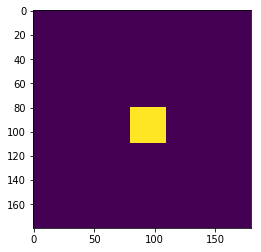

In [2035]:
plt.imshow(graph)

In [2045]:
from scipy import ndimage

In [2058]:
def b(a):
    for i in range(10):
        a.append(i)

In [2059]:
a = []
b(a)

In [2055]:
%%timeit
struct2 = ndimage.generate_binary_structure(2, 2)
np.where(dilat == 1)

1.7 ms ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [2056]:
%%timeit
dilat = 

1.48 ms ± 7.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
